In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import os
import shutil
from tqdm.auto import tqdm
import imageio
import einops
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torchvision.utils import save_image

device = torch.device("cuda:0")

from UNetSmall import *
from DDPM_gen_vis import *
from CustomizableCosineDecayScheduler import CosineDecayWithWarmUpScheduler as CD_scheduler

In [2]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
batch_size = 64

dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [3]:
def training_loop(ddpm, loader, n_epochs, optim, device, scheduler=None,
                  display=False, store_path="ddpm_model_FMNIST.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        print(f'Epoch {epoch+1}/{n_epochs}')
        
        epoch_loss = 0.0
           
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)
        
        if scheduler is not None:
            scheduler.step()
        
        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Average loss: {epoch_loss:.4f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)
        print('-' * 75)

In [ ]:
try:
    del ddpm
except: pass

n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02
ddpm = MyDDPM(UNetSmall(), n_steps=n_steps, 
              min_beta=min_beta, max_beta=max_beta, device=device)

optimizer = optim.Adam(ddpm.parameters(), betas=(0.7, 0.95),
                       lr=3e-4)

scheduler = CD_scheduler(optimizer, 
                    max_lr=3e-4, min_lr=1e-6, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)
ddpm.train()
training_loop(ddpm, loader, n_epochs=60, optim=optimizer, device=device,
             scheduler=scheduler)

In [4]:
store_path="ddpm_model_FMNIST.pt"
best_model = MyDDPM(UNetSmall(), n_steps=1000, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [5]:
torch.save(best_model.network.state_dict(), "UNet_Small_FMNIST.pt")

In [6]:
torch.cuda.empty_cache()
best_unet_small = UNetSmall()
best_unet_small.load_state_dict(torch.load("UNet_Small_FMNIST.pt", map_location=device))

best_unet_small.eval()
print("Model loaded")

Model loaded


Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

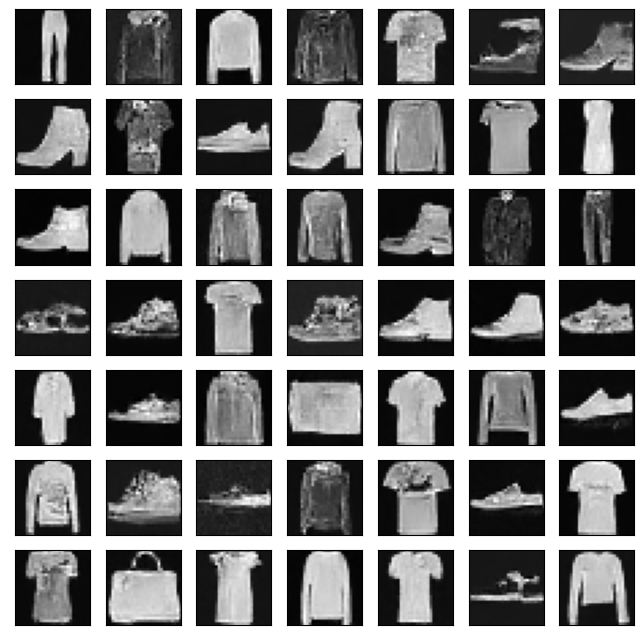

In [11]:
# check if generating works
generated = generate_new_images(
        best_unet_small,
        n_samples=49,
        device=device,
        n_steps=1000,
        from_unet=True,
        nmax=3000
    )
show_images(generated, save_path=None)

#### Generate samples with different T

In [12]:
# real samples
os.makedirs(f"datasets/FashionMNIST_png", exist_ok=True)
j = 0
for batch in tqdm(loader, desc=f"Progress", colour="#00dd00"):
    for i in range(len(batch[0])):
        save_image(torch.cat([batch[0][i],batch[0][i],batch[0][i]]), f"datasets/FashionMNIST_png/img{j+i}.png")
    
    j += i

Progress:   0%|          | 0/938 [00:00<?, ?it/s]

In [7]:
# fake samples
n_samples=50000

os.makedirs(f"generated_ddpm_FMNIST", exist_ok=True)

num_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 
             400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

for n in tqdm(num_steps, desc=f"Generating progress", colour="#00dd00"):
    
    torch.cuda.empty_cache()
    
    with torch.no_grad():

        generated = generate_new_images(
                best_unet_small,
                n_samples=n_samples,
                device=device,
                n_steps=n,
                from_unet=True,
                nmax=1000
            )

    os.makedirs(f"generated_ddpm_FMNIST/{n}", exist_ok=True)
    
    for i in range(len(generated)):
        save_image(torch.cat([generated[i],generated[i],generated[i]]), f"generated_ddpm_FMNIST/{n}/img{i}.png")

Generating progress:   0%|          | 0/28 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

Steps:   0%|          | 0/30 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/50 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

Steps:   0%|          | 0/60 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

Steps:   0%|          | 0/70 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

Steps:   0%|          | 0/80 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

Steps:   0%|          | 0/90 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

Steps:   0%|          | 0/150 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

Steps:   0%|          | 0/200 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

Steps:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

Steps:   0%|          | 0/300 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

Steps:   0%|          | 0/350 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

Steps:   0%|          | 0/400 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

Steps:   0%|          | 0/450 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

Steps:   0%|          | 0/500 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

Steps:   0%|          | 0/550 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

Steps:   0%|          | 0/600 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

Steps:   0%|          | 0/650 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

Steps:   0%|          | 0/700 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

Steps:   0%|          | 0/750 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

Steps:   0%|          | 0/800 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

Steps:   0%|          | 0/850 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

Steps:   0%|          | 0/900 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

Steps:   0%|          | 0/950 [00:00<?, ?it/s]

batches:   0%|          | 0/50 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
# extract features and calculate FID
from FID import extract_real_features, FID_score

# path_real = "datasets/FashionMNIST_png/"
# real_features = extract_real_features(path_real)

# with open('real_features.npy', "wb") as f:
#     np.save(f, real_features)
# torch.cuda.empty_cache()

with open("real_features.npy", 'rb') as f:
    real_features = np.load(f)

Feature extracting:   0%|          | 0/1182 [00:00<?, ?it/s]

In [8]:
path_real = "real_features.npy"
num_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 
             400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

scores = []

for n in tqdm(num_steps, leave=False, desc=f"Progress", colour="#009900"):
    torch.cuda.empty_cache()
    path_fake = f"generated_ddpm_FMNIST/{n}/"
    scores.append(FID_score(path_real, path_fake, True))

with open('FID_scores_FMNIST_ddpm.npy', "wb") as f:
    np.save(f, np.array(scores))

Progress:   0%|          | 0/28 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
with open('FID_scores_FMNIST_ddpm.npy', "rb") as f:
    scores = np.load(f)

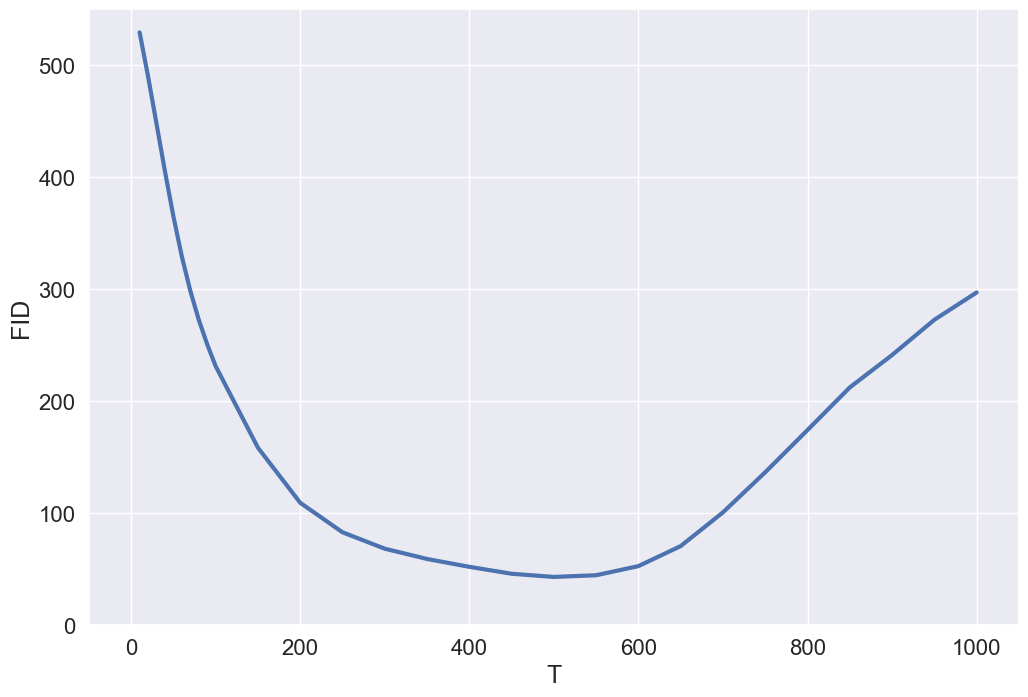

In [9]:
import seaborn as sns
sns.set_theme(style='darkgrid')
num_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 
             400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

plt.figure(figsize=(12,8))

plt.plot(num_steps, scores, lw=3)

plt.xlabel("T", fontsize=18)
plt.ylabel("FID", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=-50, right=1050)
plt.ylim(bottom=0, top=550)

plt.savefig("DDPM_FID_FMNIST.png", bbox_inches='tight')
plt.show()